In [1]:
import os
import time
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from torchmetrics import F1Score
import torch
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from nltk.tokenize import sent_tokenize

from torch_geometric.data import Dataset, Data
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from preprocess_data import load_data
from base_model import MHAClassifier, MHAClassifier_extended
from eval_models import retrieve_parameters, eval_results, filtering_matrices 
from data_loaders import create_loaders

import torch_geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import to_networkx
from sentence_transformers import SentenceTransformer

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='6'
os.environ["TOKENIZERS_PARALLELISM"] = "False"

##### Loading Pretrained -- Checking Metrics

In [3]:
in_path = "/scratch/datasets/HyperNews/"

data_train = "articles-training-byarticle-20181122.xml"
labels_train = "ground-truth-training-byarticle-20181122.xml"
data_test = "articles-test-byarticle-20181207.xml"
labels_test = "ground-truth-test-byarticle-20181207.xml"

df_full_train, df_test = load_data(in_path, data_train, labels_train, data_test, labels_test)

print ("df_train", df_full_train.shape)
print ("df_test", df_test.shape)

Loading from Processed folder
df_train (644, 4)
df_test (625, 4)


In [4]:
sent_lengths=[]
for i, doc in enumerate(df_full_train['article_text']):
    sent_in_doc = sent_tokenize(doc)
    if len(sent_in_doc)==0:
        print ("Empty doc en:", i)
    sent_lengths.append(len(sent_in_doc))
max_len = max(sent_lengths)  # Maximum number of sentences in a document
print ("max number of sentences in document:", max_len)

max number of sentences in document: 136


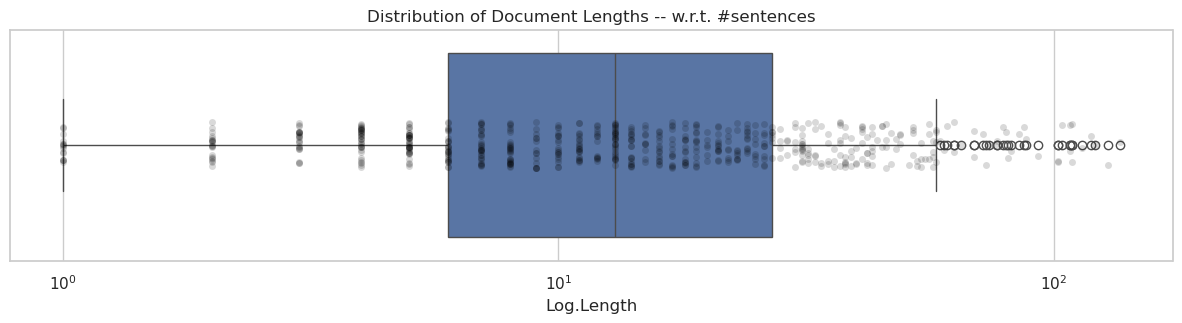

In [5]:
plt.figure(figsize=(15, 3))
sns.set_theme(style="whitegrid")
sns.boxplot(data=sent_lengths, orient='h')
sns.stripplot(data=sent_lengths, marker="o", alpha=0.15, color="black", orient='h')
plt.title("Distribution of Document Lengths -- w.r.t. #sentences")
plt.xscale('log')
plt.xlabel("Log.Length")
plt.show()

In [6]:
print (np.mean(sent_lengths))
print (np.percentile(sent_lengths, 95))
print (np.percentile(sent_lengths, 97.5))
print (np.percentile(sent_lengths, 98.5))
print (np.percentile(sent_lengths, 99))

20.517080745341616
58.85000000000002
81.92499999999995
102.71000000000004
108.57000000000005


In [6]:
path_models = "/scratch/mbugueno/HomoGraphs_HND/"
df_logger = pd.read_csv(path_models+"df_logger.csv")
df_logger.sort_values(by="Score", ascending=False, inplace=True)
df_logger.head()

,Model,Path,Score,Test score,Setting,Stop epoch,Training_time,Total_time
1,Simple_Anneal,/scratch/mbugueno/HomoGraphs_HND/Simple_Anneal...,0.792630,0.7663,config/simple_classifier_anneal.yaml,6,970.226267,1136.629423
4,Extended_Anneal,/scratch/mbugueno/HomoGraphs_HND/Extended_Anne...,0.755057,0.7839,config/ext_classifier_anneal.yaml,6,988.560711,1451.099626
3,Extended_Step,/scratch/mbugueno/HomoGraphs_HND/Extended_Step...,0.745630,0.7113,config/ext_classifier_step.yaml,4,693.588062,858.434768
0,Simple_Step,/scratch/mbugueno/HomoGraphs_HND/Simple_Step/S...,0.741449,0.7548,config/simple_classifier_step.yaml,4,709.190204,869.210780
5,Extended_NoTemp,/scratch/mbugueno/HomoGraphs_HND/Extended_NoTe...,0.733651,0.7504,config/ext_classifier.yaml,7,1100.958234,1491.809760


### Loading Trained Models - Annealing Temperature

In [8]:
batch_size = 32
num_classes = 2
std = 0.5
num_print = 5
granularity= "local"

In [9]:
path_models = "/scratch/mbugueno/HomoGraphs_HND/"
df_logger = pd.read_csv(path_models+"df_logger_cw.csv")
df_logger.sort_values(by="Score", ascending=False, inplace=True)
df_logger

,Model,Path,Score,Test score,Setting,Stop epoch,Temperature,Training_time,Total_time
1,Extended_Anneal,/scratch/mbugueno/HomoGraphs_HND/Extended_Anne...,0.825969,0.754292,config/ext_classifier_anneal.yaml,8,0.993322,177.359433,197.065697
24,Extended_ReLu,/scratch/mbugueno/HomoGraphs_HND/Extended_ReLu...,0.816595,0.761480,config/ext_classifier_relu.yaml,8,1.000000,148.643575,163.798942
3,Extended_NoTemp,/scratch/mbugueno/HomoGraphs_HND/Extended_NoTe...,0.795521,0.750323,config/ext_classifier.yaml,11,1.000000,243.935345,264.855422
4,Extended_ReLu,/scratch/mbugueno/HomoGraphs_HND/Extended_ReLu...,0.793763,0.681979,config/ext_classifier_relu.yaml,13,1.000000,287.567289,308.010903
16,Extended_Anneal,/scratch/mbugueno/HomoGraphs_HND/Extended_Anne...,0.791258,0.730660,config/ext_classifier_anneal.yaml,10,0.989951,217.886761,237.609218
25,Extended_ReLu,/scratch/mbugueno/HomoGraphs_HND/Extended_ReLu...,0.790841,0.766026,config/Classifier/multi_classifier_relu.yaml,7,1.000000,117.680212,133.219903
10,Extended_Step,/scratch/mbugueno/HomoGraphs_HND/Extended_Step...,0.788105,0.718730,config/ext_classifier_step.yaml,8,0.600000,178.458653,198.043862
23,Extended_NoTemp,/scratch/mbugueno/HomoGraphs_HND/Extended_NoTe...,0.785405,0.758378,config/ext_classifier.yaml,9,1.000000,185.448024,202.541765
22,Extended_Sigmoid,/scratch/mbugueno/HomoGraphs_HND/Extended_Sigm...,0.784413,0.712461,config/ext_classifier_sigmoid.yaml,5,1.000000,114.479252,132.766848
14,Extended_Step,/scratch/mbugueno/HomoGraphs_HND/Extended_Step...,0.781818,0.764761,config/ext_classifier_step.yaml,8,0.600000,178.481693,197.767127


In [10]:
def calculate_avg_dev_results(model_name, df_logger, multi=False):
    avg_acc_train = []
    avg_acc_test = []
    avg_f1_train = []
    avg_f1_test = []
    matched = False

    for register in df_logger.iterrows():
        if multi:
            if register[1]["Model"]==model_name and "multi" in register[1]["Setting"]:
                path_checkpoint, model_score = register[1]["Path"], register[1]["Score"]
                matched = True
            else:
                continue            
        else:
            if register[1]["Model"]==model_name and "multi" not in register[1]["Setting"]:
                path_checkpoint, model_score = register[1]["Path"], register[1]["Score"]
                matched = True
            else:    
                continue

        if matched:   
            loader_train, loader_test, _, _ = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False, tokenizer_from_scratch=False, path_ckpt=in_path)
            print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
            if multi:
                model_lightning = MHAClassifier_extended.load_from_checkpoint(path_checkpoint)
            else: 
                model_lightning = MHAClassifier.load_from_checkpoint(path_checkpoint)

            preds_t, _, all_labels_t, _, _ = model_lightning.predict(loader_train, cpu_store=False)
            preds_test, _, all_labels_test, _, _ = model_lightning.predict(loader_test, cpu_store=False)

            acc_train, f1_all_train = eval_results(preds_t, all_labels_t, num_classes, "Train", print_results=False)
            acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test", print_results=False) 
            avg_acc_train.append(acc_train)
            avg_acc_test.append(acc_test)   
            avg_f1_train.append(f1_all_train)
            avg_f1_test.append(f1_all_test) 
            #print ("Done.")
    
    avg_acc_train = torch.tensor(avg_acc_train)
    avg_acc_test = torch.tensor(avg_acc_test)
    print ("[Train] Avg. Acc:", avg_acc_train.mean().item(), "+-", avg_acc_train.std().item())
    print ("[Test] Avg. Acc:", avg_acc_test.mean().item(), "+-", avg_acc_test.std().item())
    print ("[Train] Avg. F1-score:", torch.stack(avg_f1_train, dim=0).mean(dim=0).numpy(), "+-", torch.stack(avg_f1_train, dim=0).std(dim=0).numpy())
    print ("[Test] Avg. F1-score:", torch.stack(avg_f1_test, dim=0).mean(dim=0).numpy(), "+-", torch.stack(avg_f1_test, dim=0).std(dim=0).numpy())
    return


In [8]:
calculate_avg_dev_results("Extended_Anneal", df_logger)


Loading Extended_Anneal (0.826 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Anneal/Extended_Anneal-epoch=03-Val_f1-ma=0.83.ckpt

Loading Extended_Anneal (0.791 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Anneal/Extended_Anneal-epoch=05-Val_f1-ma=0.79.ckpt

Loading Extended_Anneal (0.721 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Anneal/Extended_Anneal-epoch=01-Val_f1-ma=0.72.ckpt

Loading Extended_Anneal (0.715 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Anneal/Extended_Anneal-epoch=04-Val_f1-ma=0.72-v1.ckpt

Loading Extended_Anneal (0.668 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Anneal/Extended_Anneal-epoch=07-Val_f1-ma=0.67.ckpt
[Train] Avg. Acc: 0.8428571820259094 +- 0.08047162741422653
[Test] Avg. Acc: 0.7315199971199036 +- 0.023471521213650703
[Train] Avg. F1-score: [0.86258364 0.8109802 ] +- [0.08338012 0.07224598]
[Test] Avg. F1-score: [0.7198496 0.7300785] +- [0.05914272 0.05398193]


In [8]:
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_Anneal").dropna()

,Model,Score,Test score
1,Extended_Anneal,0.825969,0.754292
16,Extended_Anneal,0.791258,0.730660
20,Extended_Anneal,0.721135,0.749029
5,Extended_Anneal,0.715201,0.702476
11,Extended_Anneal,0.668426,0.688363


In [9]:
calculate_avg_dev_results("Extended_ReLu", df_logger)


Loading Extended_ReLu (0.817 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=04-Val_f1-ma=0.82.ckpt

Loading Extended_ReLu (0.794 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=08-Val_f1-ma=0.79.ckpt

Loading Extended_ReLu (0.769 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=08-Val_f1-ma=0.77.ckpt

Loading Extended_ReLu (0.747 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=07-Val_f1-ma=0.75.ckpt

Loading Extended_ReLu (0.732 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=03-Val_f1-ma=0.73.ckpt
[Train] Avg. Acc: 0.9145962595939636 +- 0.029564348980784416
[Test] Avg. Acc: 0.7379200458526611 +- 0.028875449672341347
[Train] Avg. F1-score: [0.9325427 0.8832773] +- [0.02259801 0.04307005]
[Test] Avg. F1-score: [0.74712896 0.72596794] +- [0.01420385 0.05049893]


In [20]:
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_ReLu").dropna()

,Model,Score,Test score
24,Extended_ReLu,0.816595,0.761480
4,Extended_ReLu,0.793763,0.681979
9,Extended_ReLu,0.769147,0.740783
21,Extended_ReLu,0.747435,0.748797
15,Extended_ReLu,0.731548,0.749702


In [11]:
calculate_avg_dev_results("Extended_ReLu", df_logger, multi=True)
tempo= df_logger[['Model', 'Score', 'Test score', 'Setting']].where(df_logger['Model']=="Extended_ReLu").dropna()
tempo.where(tempo['Setting']=="config/Classifier/multi_classifier_relu.yaml").dropna()


Loading Extended_ReLu (0.791 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=02-Val_f1-ma=0.79.ckpt

Loading Extended_ReLu (0.760 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=07-Val_f1-ma=0.76.ckpt

Loading Extended_ReLu (0.725 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=01-Val_f1-ma=0.73.ckpt

Loading Extended_ReLu (0.719 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=01-Val_f1-ma=0.72.ckpt

Loading Extended_ReLu (0.709 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=02-Val_f1-ma=0.71.ckpt
[Train] Avg. Acc: 0.8633540272712708 +- 0.046493202447891235
[Test] Avg. Acc: 0.7452800273895264 +- 0.026227299124002457
[Train] Avg. F1-score: [0.8884367  0.82245237] +- [0.0380113  0.06375874]
[Test] Avg. F1-score: [0.74483186 0.74375767] +- [0.03030628 0.03456736]


,Model,Score,Test score,Setting
25,Extended_ReLu,0.790841,0.766026,config/Classifier/multi_classifier_relu.yaml
26,Extended_ReLu,0.759800,0.745558,config/Classifier/multi_classifier_relu.yaml
29,Extended_ReLu,0.725362,0.734362,config/Classifier/multi_classifier_relu.yaml
28,Extended_ReLu,0.719170,0.704328,config/Classifier/multi_classifier_relu.yaml
27,Extended_ReLu,0.708815,0.771200,config/Classifier/multi_classifier_relu.yaml


In [10]:
calculate_avg_dev_results("Extended_Sigmoid", df_logger)


Loading Extended_Sigmoid (0.784 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Sigmoid/Extended_Sigmoid-epoch=00-Val_f1-ma=0.78.ckpt

Loading Extended_Sigmoid (0.764 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Sigmoid/Extended_Sigmoid-epoch=04-Val_f1-ma=0.76.ckpt

Loading Extended_Sigmoid (0.742 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Sigmoid/Extended_Sigmoid-epoch=07-Val_f1-ma=0.74-v1.ckpt

Loading Extended_Sigmoid (0.732 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Sigmoid/Extended_Sigmoid-epoch=00-Val_f1-ma=0.73.ckpt

Loading Extended_Sigmoid (0.729 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Sigmoid/Extended_Sigmoid-epoch=10-Val_f1-ma=0.73.ckpt
[Train] Avg. Acc: 0.8621118664741516 +- 0.09537626802921295
[Test] Avg. Acc: 0.7376000285148621 +- 0.017780890688300133
[Train] Avg. F1-score: [0.8887612 0.8163079] +- [0.07940448 0.12524727]
[Test] Avg. F1-score: [0.7431902  0.73008096] +- [0.01108637 0.03354705]


In [18]:
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_Sigmoid").dropna()

,Model,Score,Test score
22,Extended_Sigmoid,0.784413,0.712461
18,Extended_Sigmoid,0.763562,0.764453
13,Extended_Sigmoid,0.741965,0.737244
0,Extended_Sigmoid,0.732404,0.737109
7,Extended_Sigmoid,0.728811,0.731911


In [11]:
calculate_avg_dev_results("Extended_Step", df_logger)


Loading Extended_Step (0.788 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Step/Extended_Step-epoch=03-Val_f1-ma=0.79.ckpt

Loading Extended_Step (0.782 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Step/Extended_Step-epoch=03-Val_f1-ma=0.78.ckpt

Loading Extended_Step (0.779 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Step/Extended_Step-epoch=04-Val_f1-ma=0.78.ckpt

Loading Extended_Step (0.718 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Step/Extended_Step-epoch=04-Val_f1-ma=0.72.ckpt

Loading Extended_Step (0.711 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Step/Extended_Step-epoch=02-Val_f1-ma=0.71.ckpt
[Train] Avg. Acc: 0.8782609105110168 +- 0.03751855716109276
[Test] Avg. Acc: 0.7427200078964233 +- 0.019012408331036568
[Train] Avg. F1-score: [0.90204704 0.8386399 ] +- [0.03208442 0.04569668]
[Test] Avg. F1-score: [0.7422153 0.7414384] +- [0.01870056 0.0312293 ]


In [17]:
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_Step").dropna()

,Model,Score,Test score
10,Extended_Step,0.788105,0.718730
14,Extended_Step,0.781818,0.764761
19,Extended_Step,0.779197,0.735216
2,Extended_Step,0.717743,0.731911
6,Extended_Step,0.710593,0.758516


In [12]:
calculate_avg_dev_results("Extended_NoTemp", df_logger)


Loading Extended_NoTemp (0.796 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_NoTemp/Extended_NoTemp-epoch=06-Val_f1-ma=0.80.ckpt

Loading Extended_NoTemp (0.785 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_NoTemp/Extended_NoTemp-epoch=04-Val_f1-ma=0.79.ckpt

Loading Extended_NoTemp (0.775 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_NoTemp/Extended_NoTemp-epoch=06-Val_f1-ma=0.77.ckpt

Loading Extended_NoTemp (0.773 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_NoTemp/Extended_NoTemp-epoch=03-Val_f1-ma=0.77.ckpt

Loading Extended_NoTemp (0.726 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_NoTemp/Extended_NoTemp-epoch=04-Val_f1-ma=0.73-v1.ckpt
[Train] Avg. Acc: 0.8968943357467651 +- 0.03379960358142853
[Test] Avg. Acc: 0.7388800382614136 +- 0.024926144629716873
[Train] Avg. F1-score: [0.917545  0.8611859] +- [0.02511175 0.05410941]
[Test] Avg. F1-score: [0.7439019  0.73054403] +- [0.00782133 0.0516857 ]


In [16]:
df_logger[['Model', 'Score', 'Test score']].where(df_logger['Model']=="Extended_NoTemp").dropna()

,Model,Score,Test score
3,Extended_NoTemp,0.795521,0.750323
23,Extended_NoTemp,0.785405,0.758378
17,Extended_NoTemp,0.774889,0.739133
12,Extended_NoTemp,0.772683,0.688497
8,Extended_NoTemp,0.725621,0.749784


### Best- model by setting 

In [22]:
model_name= "Extended_Anneal"
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
loader_train, loader_test, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False,
                                                                                               tokenizer_from_scratch=False, path_ckpt=in_path)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHAClassifier.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_t, full_attn_weights_t, all_labels_t, all_doc_ids_t, all_article_identifiers_t = model_lightning.predict(loader_train, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_t, f1_all_t = eval_results(preds_t, all_labels_t, num_classes, "Train")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Anneal (0.826 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Anneal/Extended_Anneal-epoch=03-Val_f1-ma=0.83.ckpt
Model temperature 0.9933223949566841

Trained Model Results on partition: Train
Train Acc: tensor(0.8898)
Train F1-score macro: tensor(0.8848)
Train F1-score for each class: tensor([0.9086, 0.8611])

Trained Model Results on partition: Test
Test Acc: tensor(0.7552)
Test F1-score macro: tensor(0.7543)
Test F1-score for each class: tensor([0.7394, 0.7692])


In [23]:
model_name= "Extended_ReLu" 
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
loader_train, loader_test, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False,
                                                                                               tokenizer_from_scratch=False, path_ckpt=in_path)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHAClassifier.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_t, full_attn_weights_t, all_labels_t, all_doc_ids_t, all_article_identifiers_t = model_lightning.predict(loader_train, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_t, f1_all_t = eval_results(preds_t, all_labels_t, num_classes, "Train")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_ReLu (0.817 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=04-Val_f1-ma=0.82.ckpt
Model temperature 1

Trained Model Results on partition: Train
Train Acc: tensor(0.9363)
Train F1-score macro: tensor(0.9326)
Train F1-score for each class: tensor([0.9484, 0.9168])

Trained Model Results on partition: Test
Test Acc: tensor(0.7616)
Test F1-score macro: tensor(0.7615)
Test F1-score for each class: tensor([0.7561, 0.7668])


In [12]:
### 2-Layer MHA -- ReLu
model_name= "Extended_ReLu" 
num_classes = 2
setting_file= "config/Classifier/multi_classifier_relu.yaml"
tempo= df_logger.where(df_logger['Setting']==setting_file).dropna()
path_checkpoint, model_score = retrieve_parameters(model_name, tempo)
loader_train, loader_test, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False,
                                                                                               tokenizer_from_scratch=False, path_ckpt=in_path)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHAClassifier_extended.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_t, full_attn_weights_t, all_labels_t, all_doc_ids_t, all_article_identifiers_t = model_lightning.predict(loader_train, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_t, f1_all_t = eval_results(preds_t, all_labels_t, num_classes, "Train")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_ReLu (0.791 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=02-Val_f1-ma=0.79.ckpt
Model temperature 1

Trained Model Results on partition: Train
Train Acc: tensor(0.9130)
Train F1-score macro: tensor(0.9070)
Train F1-score for each class: tensor([0.9307, 0.8833])

Trained Model Results on partition: Test
Test Acc: tensor(0.7664)
Test F1-score macro: tensor(0.7660)
Test F1-score for each class: tensor([0.7754, 0.7567])


In [9]:
model_name= "Extended_Sigmoid" 
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger, require_best=False, retrieve_index=18)
loader_train, loader_test, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False,
                                                                                               tokenizer_from_scratch=False, path_ckpt=in_path)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHAClassifier.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_t, full_attn_weights_t, all_labels_t, all_doc_ids_t, all_article_identifiers_t = model_lightning.predict(loader_train, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_t, f1_all_t = eval_results(preds_t, all_labels_t, num_classes, "Train")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Sigmoid (0.764 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Sigmoid/Extended_Sigmoid-epoch=04-Val_f1-ma=0.76.ckpt
Model temperature 1

Trained Model Results on partition: Train
Train Acc: tensor(0.9208)
Train F1-score macro: tensor(0.9165)
Train F1-score for each class: tensor([0.9355, 0.8974])

Trained Model Results on partition: Test
Test Acc: tensor(0.7648)
Test F1-score macro: tensor(0.7645)
Test F1-score for each class: tensor([0.7554, 0.7735])


In [10]:
model_name= "Extended_Step" 
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger, require_best=False, retrieve_index=14)
loader_train, loader_test, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False,
                                                                                               tokenizer_from_scratch=False, path_ckpt=in_path)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHAClassifier.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_t, full_attn_weights_t, all_labels_t, all_doc_ids_t, all_article_identifiers_t = model_lightning.predict(loader_train, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_t, f1_all_t = eval_results(preds_t, all_labels_t, num_classes, "Train")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Step (0.782 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Step/Extended_Step-epoch=03-Val_f1-ma=0.78.ckpt
Model temperature 0.6000000000000001

Trained Model Results on partition: Train
Train Acc: tensor(0.8587)
Train F1-score macro: tensor(0.8477)
Train F1-score for each class: tensor([0.8886, 0.8068])

Trained Model Results on partition: Test
Test Acc: tensor(0.7648)
Test F1-score macro: tensor(0.7648)
Test F1-score for each class: tensor([0.7678, 0.7618])


In [11]:
model_name= "Extended_NoTemp" 
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger, require_best=False, retrieve_index=23)
loader_train, loader_test, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False,
                                                                                               tokenizer_from_scratch=False, path_ckpt=in_path)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHAClassifier.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_t, full_attn_weights_t, all_labels_t, all_doc_ids_t, all_article_identifiers_t = model_lightning.predict(loader_train, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_t, f1_all_t = eval_results(preds_t, all_labels_t, num_classes, "Train")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_NoTemp (0.785 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_NoTemp/Extended_NoTemp-epoch=04-Val_f1-ma=0.79.ckpt
Model temperature 1

Trained Model Results on partition: Train
Train Acc: tensor(0.8804)
Train F1-score macro: tensor(0.8742)
Train F1-score for each class: tensor([0.9022, 0.8463])

Trained Model Results on partition: Test
Test Acc: tensor(0.7584)
Test F1-score macro: tensor(0.7584)
Test F1-score for each class: tensor([0.7561, 0.7607])


#### Post predict -- crear filenames de acuerdo a filter type

##### Mean

In [12]:
filter_type = "mean"

path_root="/scratch/datasets/AttnGraphs_HND/"+model_name+"/"+filter_type
path_dataset = path_root+"/raw/"

filename="post_predict_train_documents.csv"
filename_test= "post_predict_test_documents.csv" 

In [13]:
print ("\nCreating file for PyG dataset in:", path_dataset)
post_predict_train_docs = pd.DataFrame(columns=["article_id", "label", "doc_as_ids"])
post_predict_train_docs.to_csv(path_dataset+"post_predict_train_documents.csv", index=False)

for article_id, label, doc_as_ids in zip(all_article_identifiers_t, all_labels_t, all_doc_ids_t):
    post_predict_train_docs.loc[len(post_predict_train_docs)] = {
    "article_id": article_id.item(),
    "label": label.item(), 
    "doc_as_ids": doc_as_ids.tolist()
    }
post_predict_train_docs.to_csv(path_dataset+"post_predict_train_documents.csv", index=False)
print ("Finished and saved in:", path_dataset+"post_predict_train_documents.csv")


post_predict_test_docs = pd.DataFrame(columns=["article_id", "label", "doc_as_ids"])
post_predict_test_docs.to_csv(path_dataset+"post_predict_test_documents.csv", index=False)

for article_id, label, doc_as_ids in zip(all_article_identifiers_test, all_labels_test, all_doc_ids_test):
    post_predict_test_docs.loc[len(post_predict_test_docs)] = {
    "article_id": article_id.item(),
    "label": label.item(), 
    "doc_as_ids": doc_as_ids.tolist()
    }
post_predict_test_docs.to_csv(path_dataset+"post_predict_test_documents.csv", index=False)
print ("Finished and saved in:", path_dataset+"post_predict_test_documents.csv")


Creating file for PyG dataset in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/mean/raw/
Finished and saved in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/mean/raw/post_predict_train_documents.csv
Finished and saved in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/mean/raw/post_predict_test_documents.csv


In [14]:
dataset = AttentionGraphs(root=path_root, filename=filename, filter_type=filter_type, input_matrices=full_attn_weights_t, degree=0.5, test=False) 
dataset_test = AttentionGraphs(root=path_root, filename=filename_test, filter_type=filter_type, input_matrices=full_attn_weights_test, degree=0.5, test=True)

Processing...



Filtering Attention Weights based on Mean and Std Deviation
[Train] Creating Graphs Objects...


100%|██████████| 644/644 [19:13<00:00,  1.79s/it]
Done!
Processing...



Filtering Attention Weights based on Mean and Std Deviation
[Test] Creating Graphs Objects...


100%|██████████| 625/625 [18:33<00:00,  1.78s/it]
Done!


##### Max

In [15]:
filter_type = "max"

path_root="/scratch/datasets/AttnGraphs_HND/"+model_name+"/"+filter_type
path_dataset = path_root+"/raw/"

In [16]:
print ("\nCreating file for PyG dataset in:", path_dataset)
post_predict_train_docs = pd.DataFrame(columns=["article_id", "label", "doc_as_ids"])
post_predict_train_docs.to_csv(path_dataset+"post_predict_train_documents.csv", index=False)

for article_id, label, doc_as_ids in zip(all_article_identifiers_t, all_labels_t, all_doc_ids_t):
    post_predict_train_docs.loc[len(post_predict_train_docs)] = {
    "article_id": article_id.item(),
    "label": label.item(), 
    "doc_as_ids": doc_as_ids.tolist()
    }
post_predict_train_docs.to_csv(path_dataset+"post_predict_train_documents.csv", index=False)
print ("Finished and saved in:", path_dataset+"post_predict_train_documents.csv")


post_predict_test_docs = pd.DataFrame(columns=["article_id", "label", "doc_as_ids"])
post_predict_test_docs.to_csv(path_dataset+"post_predict_test_documents.csv", index=False)

for article_id, label, doc_as_ids in zip(all_article_identifiers_test, all_labels_test, all_doc_ids_test):
    post_predict_test_docs.loc[len(post_predict_test_docs)] = {
    "article_id": article_id.item(),
    "label": label.item(), 
    "doc_as_ids": doc_as_ids.tolist()
    }
post_predict_test_docs.to_csv(path_dataset+"post_predict_test_documents.csv", index=False)
print ("Finished and saved in:", path_dataset+"post_predict_test_documents.csv")


Creating file for PyG dataset in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/max/raw/
Finished and saved in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/max/raw/post_predict_train_documents.csv
Finished and saved in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/max/raw/post_predict_test_documents.csv


In [17]:
dataset = AttentionGraphs(root=path_root, filename=filename, filter_type=filter_type, input_matrices=full_attn_weights_t, degree=0.5, test=False) 
dataset_test = AttentionGraphs(root=path_root, filename=filename_test, filter_type=filter_type, input_matrices=full_attn_weights_test, degree=0.5, test=True)


Filtering Attention Weights based on Mean and Std Deviation


Processing...


[Train] Creating Graphs Objects...


100%|██████████| 644/644 [19:08<00:00,  1.78s/it]
Done!
Processing...



Filtering Attention Weights based on Mean and Std Deviation
[Test] Creating Graphs Objects...


100%|██████████| 625/625 [18:23<00:00,  1.77s/it]
Done!


##### Full - No filter applied

In [22]:
filter_type = None
path_root="/scratch/datasets/AttnGraphs_HND/"+model_name+"/full"
path_dataset = path_root+"/raw/"


In [23]:
print ("\nCreating file for PyG dataset in:", path_dataset)
post_predict_train_docs = pd.DataFrame(columns=["article_id", "label", "doc_as_ids"])
post_predict_train_docs.to_csv(path_dataset+"post_predict_train_documents.csv", index=False)

for article_id, label, doc_as_ids in zip(all_article_identifiers_t, all_labels_t, all_doc_ids_t):
    post_predict_train_docs.loc[len(post_predict_train_docs)] = {
    "article_id": article_id.item(),
    "label": label.item(), 
    "doc_as_ids": doc_as_ids.tolist()
    }
post_predict_train_docs.to_csv(path_dataset+"post_predict_train_documents.csv", index=False)
print ("Finished and saved in:", path_dataset+"post_predict_train_documents.csv")


post_predict_test_docs = pd.DataFrame(columns=["article_id", "label", "doc_as_ids"])
post_predict_test_docs.to_csv(path_dataset+"post_predict_test_documents.csv", index=False)

for article_id, label, doc_as_ids in zip(all_article_identifiers_test, all_labels_test, all_doc_ids_test):
    post_predict_test_docs.loc[len(post_predict_test_docs)] = {
    "article_id": article_id.item(),
    "label": label.item(), 
    "doc_as_ids": doc_as_ids.tolist()
    }
post_predict_test_docs.to_csv(path_dataset+"post_predict_test_documents.csv", index=False)
print ("Finished and saved in:", path_dataset+"post_predict_test_documents.csv")


Creating file for PyG dataset in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/full/raw/
Finished and saved in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/full/raw/post_predict_train_documents.csv
Finished and saved in: /scratch/datasets/AttnGraphs_HND/Extended_Anneal/full/raw/post_predict_test_documents.csv


In [24]:
dataset = AttentionGraphs(root=path_root, filename=filename, filter_type=filter_type, input_matrices=full_attn_weights_t, degree=0.5, test=False) 
dataset_test = AttentionGraphs(root=path_root, filename=filename_test, filter_type=filter_type, input_matrices=full_attn_weights_test, degree=0.5, test=True)

Processing...



Generating Graphs Objects based on Full Attention Weights
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold 

100%|██████████| 644/644 [25:44<00:00,  2.40s/it]
Done!
Processing...



Generating Graphs Objects based on Full Attention Weights
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold was calculated.
No threshold 

100%|██████████| 625/625 [23:45<00:00,  2.28s/it]  
Done!


##### Simple Model ?? solo si es necesario comparar mas adelante. Continuar con GNNs y graphs visualizacion HTML

### Matrix Visualization 
#### ReLu 

In [12]:
model_name= "Extended_ReLu" 
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger)
loader_train, loader_test, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False,
                                                                                               tokenizer_from_scratch=False, path_ckpt=in_path)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHAClassifier.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_t, full_attn_weights_t, all_labels_t, all_doc_ids_t, all_article_identifiers_t = model_lightning.predict(loader_train, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_t, f1_all_t = eval_results(preds_t, all_labels_t, num_classes, "Train")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_ReLu (0.817 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_ReLu/Extended_ReLu-epoch=04-Val_f1-ma=0.82.ckpt
Model temperature 1

Trained Model Results on partition: Train
Train Acc: tensor(0.9363)
Train F1-score macro: tensor(0.9326)
Train F1-score for each class: tensor([0.9484, 0.9168])

Trained Model Results on partition: Test
Test Acc: tensor(0.7616)
Test F1-score macro: tensor(0.7615)
Test F1-score for each class: tensor([0.7561, 0.7668])



Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  0 -- #Sentences:  60
Source text:
  Money (  The walls are closing in on Congress. Terrifying walls of water from Hurricanes Harvey and Irma, which, when the damage is totaled, could rise to a half trillion dollars. The Walls of War: The multi trillion dollar ongoing cost of Afghanistan, Iraq and other interventions. The crumbling walls of the U.S. infrastructure, which need at least $3 trillion to be repaired or replaced. A wall of 11 million undocumented immigrants, whose deportation could easily cost $200 billion. The planned wall at the Mexican border, which some estimates place at $67 billion. Then there is the Wall of All, the $20 trillion national debt. The walls of debt are closing in. At moments of crisis in our nation, in addition to invoking the assistance of Higher powers, we can call upon the Constitution for guidance. Article I, Section 8, of the U.S. Constitution contains a long forgotten pro

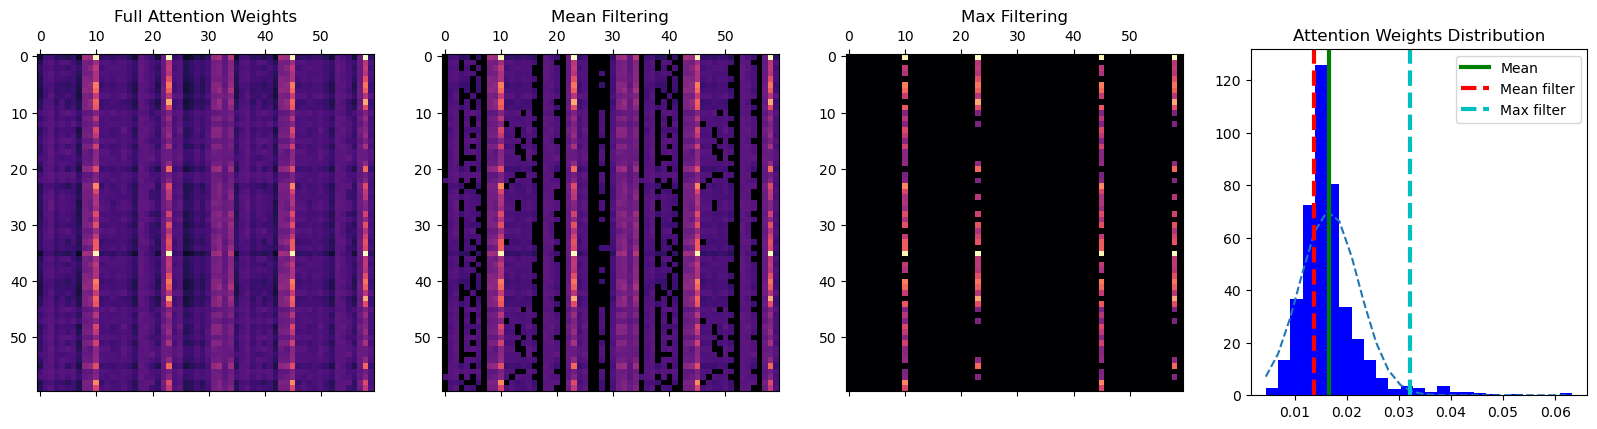


Document ID:  2 -- #Sentences:  11
Source text:
  In response to Joyce Newman’s recent letter about a conversation about guns: According to the National Right to Life Organization, approximately 600,000 babies are murdered every year by Planned Parenthood with more than 52 million murdered since Roe v. Wade. This makes Planned Parenthood the biggest mass murderer in the history of the world. Is she willing to have a serious conversation about that? Where is her outrage over that? More people die every year from overdoses or auto accidents then from guns. More people die every year from obesity then from guns. Where is her outrage over those issues? The left’s obsession with gun “control” is just that, control. It has always been about Democrats wanting to control every aspect of your life. They support Planned Parenthood but go ballistic when a gun is used to kill someone. It’s the old game of “don’t pay any attention to what’s going on over there, but look what’s happening here.”
Aft

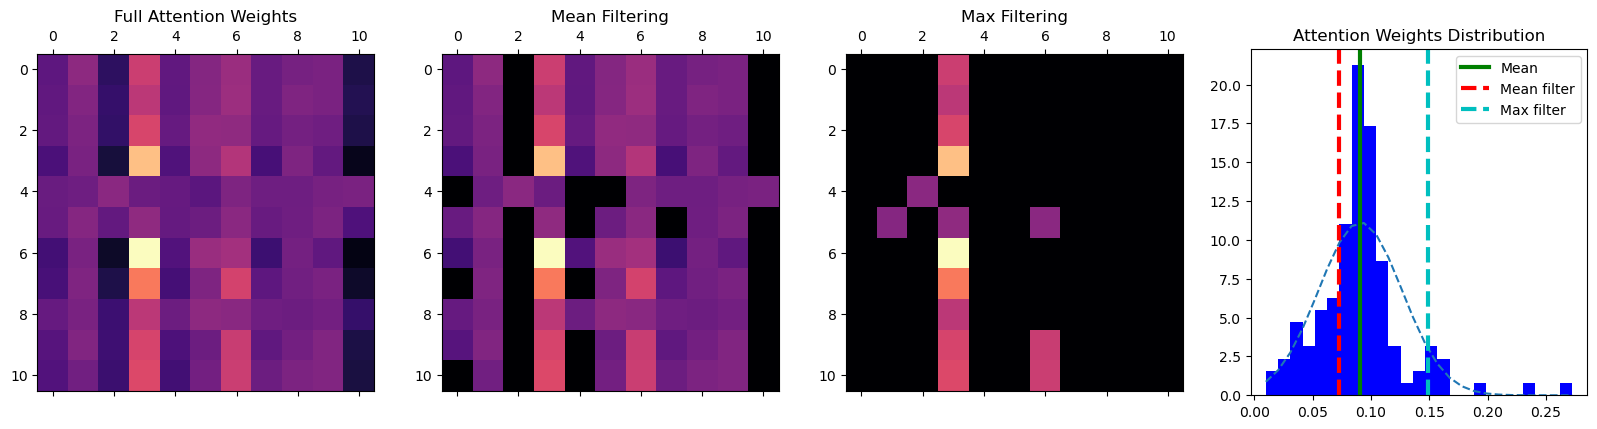


Document ID:  3 -- #Sentences:  17
Source text:
  After Colin Kaepernick rightly chose to kneel during the national anthem before NFL games, many racists and idiots came out with critical response to what was a peaceful, important statement against police brutality and systemic American racism. That’s what Kap’s protest is about. Brutality and racism. Violence against people of color, unimpugned state violence at that. Kap’s protest is strictly against racism, which is what this country was built on. On the backs of African slaves shipped here catch style to do white people’s work. Kap’s protest is decidedly not against the American flag. Anyone — including our moron President — that tries to argue otherwise is themselves a moron. “But the troops!” you might scream. The troops are a manifold and variegated thing.  Here’s a picture of  He kneels at left. Hat off to Tunsil for this action. “Respecting the flag” and “respecting the anthem” before football games are perhaps the dumbest no

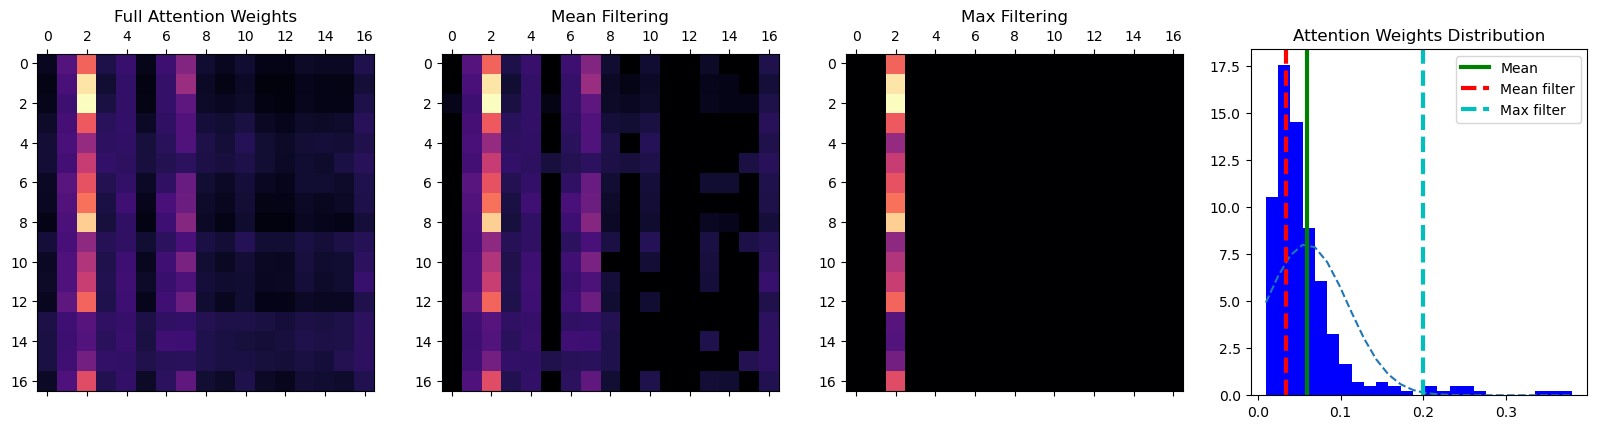


Document ID:  4 -- #Sentences:  45
Source text:
  Almost a half century ago, in 1968, the United States seemed to be falling apart. The Vietnam War, a bitter and close presidential election, antiwar protests, racial riots, political assassinations, terrorism and a recession looming on the horizon left the country divided between a loud radical minority and a silent conservative majority. The United States avoided a civil war. But America suffered a collective psychological depression, civil unrest, defeat in Vietnam and assorted disasters for the next decade    until the election of a once polarizing Ronald Reagan ushered in five consecutive presidential terms of relative bipartisan calm and prosperity from 1981 to 2001. It appears as if 2017 might be another 1968. Recent traumatic hurricanes seem to reflect the country s human turmoil. After the polarizing Obama presidency and the contested election of Donald Trump, the country is once again split in two. But this time the divide is 

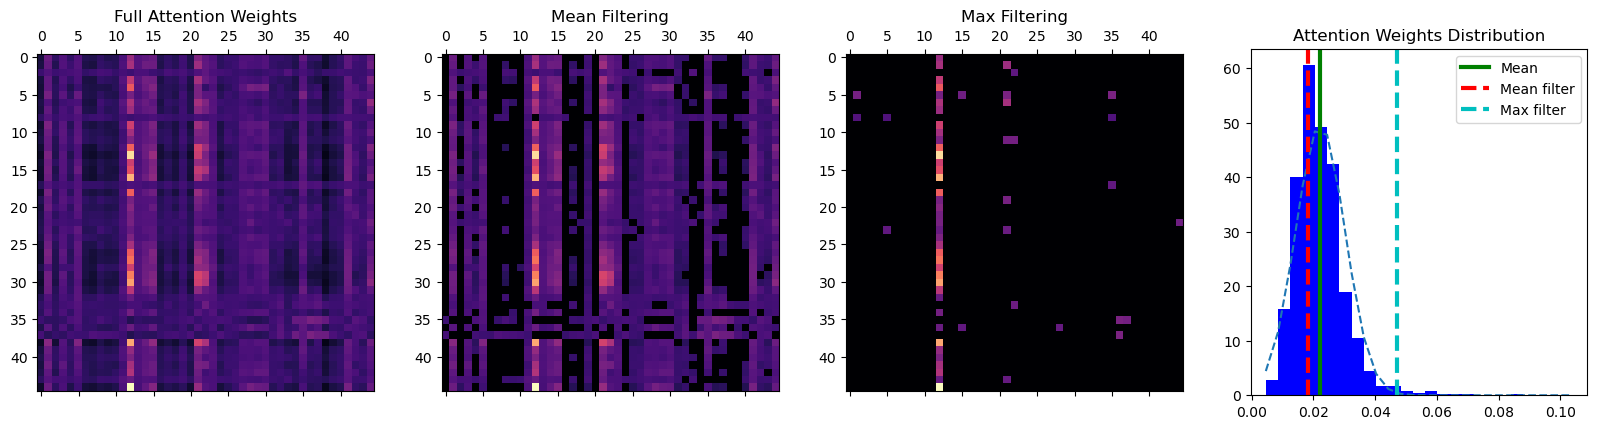


Document ID:  5 -- #Sentences:  109
Source text:
  Briefly: In our opinion, full (150% of the regular full position) speculative short positions in gold, silver and mining stocks are justified from the risk/reward perspective at the moment of publishing this alert. Gold moved back and forth on Friday and the accompanying volume was high, but that’s not the only important thing that we can discuss today. The week is over and we have weekly changes and weekly volume levels to analyze and we saw major moves in the important ratios. Additionally, we discovered a self similar pattern in gold that has critical and volatile implications going forward. Let’s start with Friday’s session and the changes in the gold market (chart courtesy of  Gold moved sharply back and forth as both positive and negative data was released and ultimately it ended the session a few dollars higher (based on kitco’s prices, the closing price was $1,279.60). Why was the reaction so significant? The reason could be t

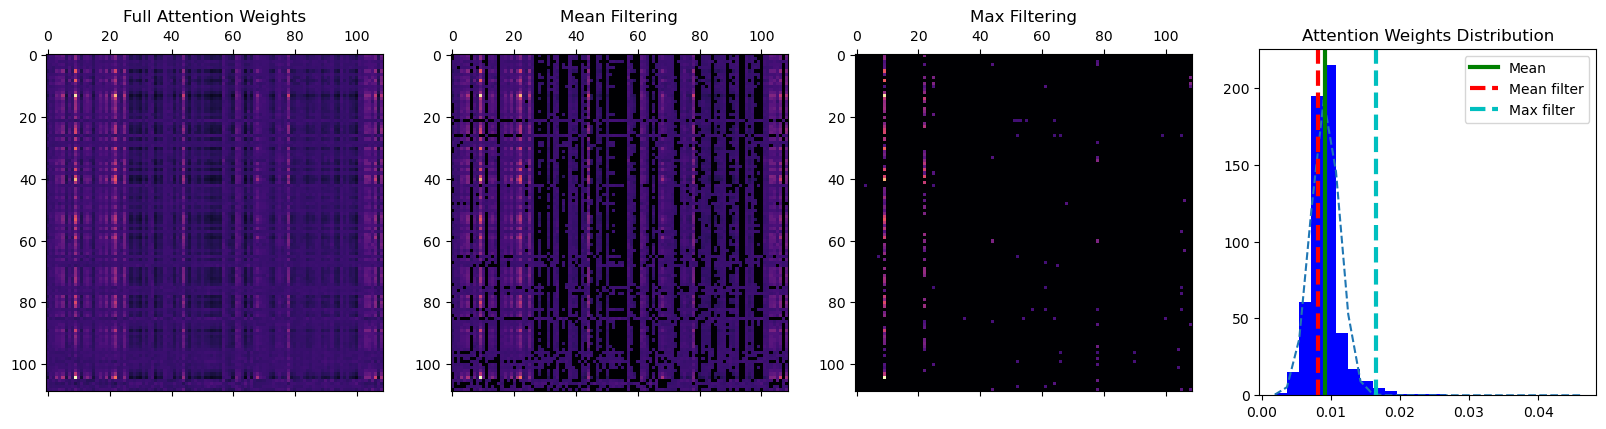

Done.

Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  661 -- #Sentences:  10
Source text:
  Members of Texas Vanguard, a white supremacist group, hung racist and homophobic propaganda across the Southern Methodist University campus in Dallas over the weekend. “White men! Save your people. Reject the opioid beast!” was the message on a banner posted at the lacrosse field. The group touted its work on Twitter, “We had a great night @SMU,” sharing photos of masked members posing next to the banners while giving the Nazi salute.   Other messages said the LGBT community has “misplaced pride” and “Reclaim America. No more tolerance, no more diversity.” “While SMU strongly supports freedom of speech and expression, the outside group featured on these signs promotes an abhorrent message that is opposite to SMU values. Our University community is deeply committed to maintaining an educational environment that is welcoming and inclusive. As an institution dedicate

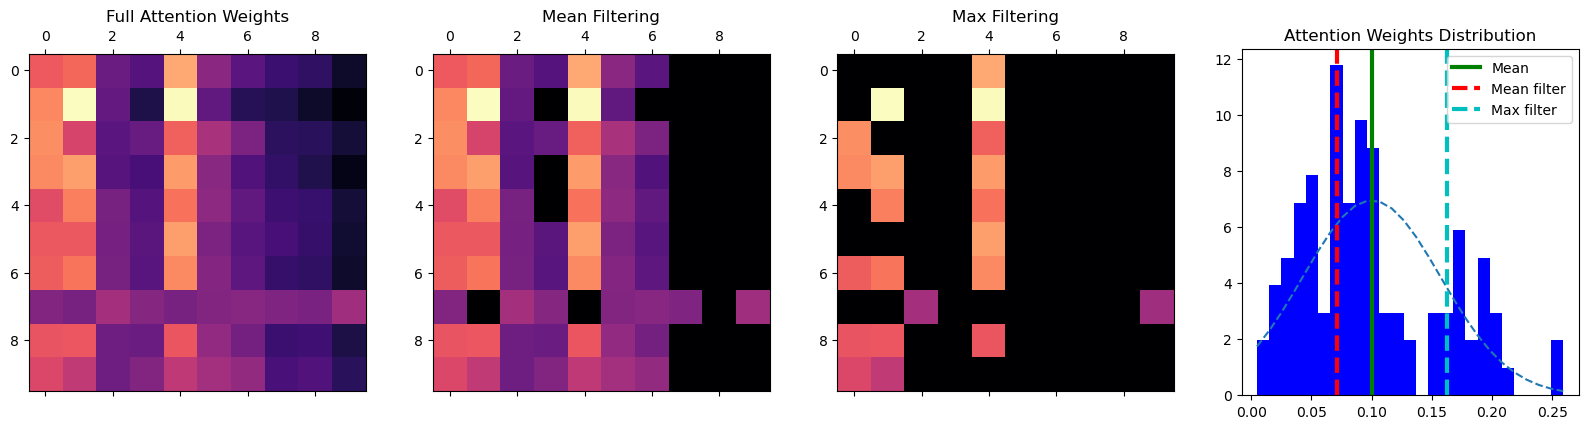


Document ID:  664 -- #Sentences:  12
Source text:
  FBI special agent Aaron Rouse, the chief of the FBI’s Las Vegas office, revealed Wednesday that the agency might not be able to reveal Las Vegas shooter Stephen Paddock’s motive until October. Rouse, who spoke to the  “Now that’s a long time for some people, but speaking for the FBI, that’s light speed, all right?” Rouse said. “And again, it will be thorough.” “[The FBI’s report] is focusing a large part on the why, OK? Which is what everybody wants to know,” Rouse reported. He added that through a thorough investigation of the incident, including those whom the FBI interviewed — upward of 400 people who had even the smallest connection with Paddock, according to the Review Journal — he is confident that a comprehensive report will be released by October. “I’ve said this before: I believe at the end of this investigation we will have as many answers as we possibly can without talking to the subject themselves,” Rouse explained. “I am

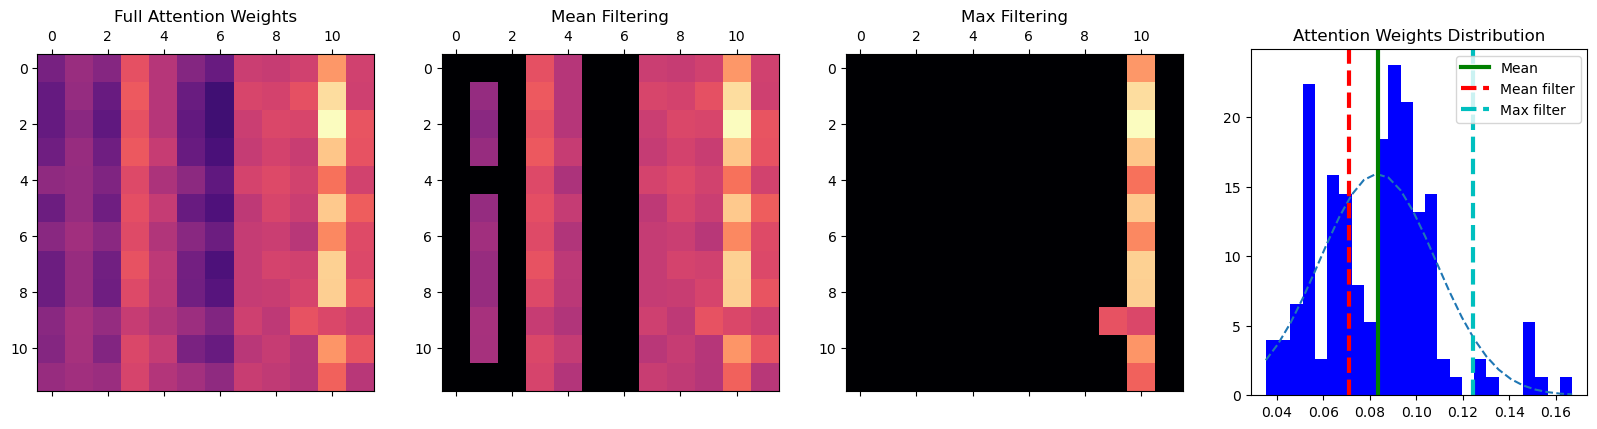


Document ID:  667 -- #Sentences:  31
Source text:
  After a few weeks off,  The comedian addressed the week’s biggest controversy during his monologue—Trump finally acknowledging after being at the forefront of a five year racist crusade against the first black president that Barack Obama was born in the United States. As is his wont, the bloated ex reality show host delivered the news  “He blamed it on Hillary. Of course,” said Maher, rolling his eyes. “Because even when [Trump] admits he lies, he has to tell another giant lie! He says Hillary and her campaign started birtherism in 2008, which is something contradicted only by newspapers, television, Twitter, eyes, ears, and smell. Hillary started birtherism? Oh yes, I think we all remember that. I think it was right after Hillary’s casinos went bankrupt.” A softball, Fallon esque softball interview with Trump campaign manager Kellyanne Conway—who’s been a guest and pal of Maher’s for twenty years dating back to his ABC series Politi

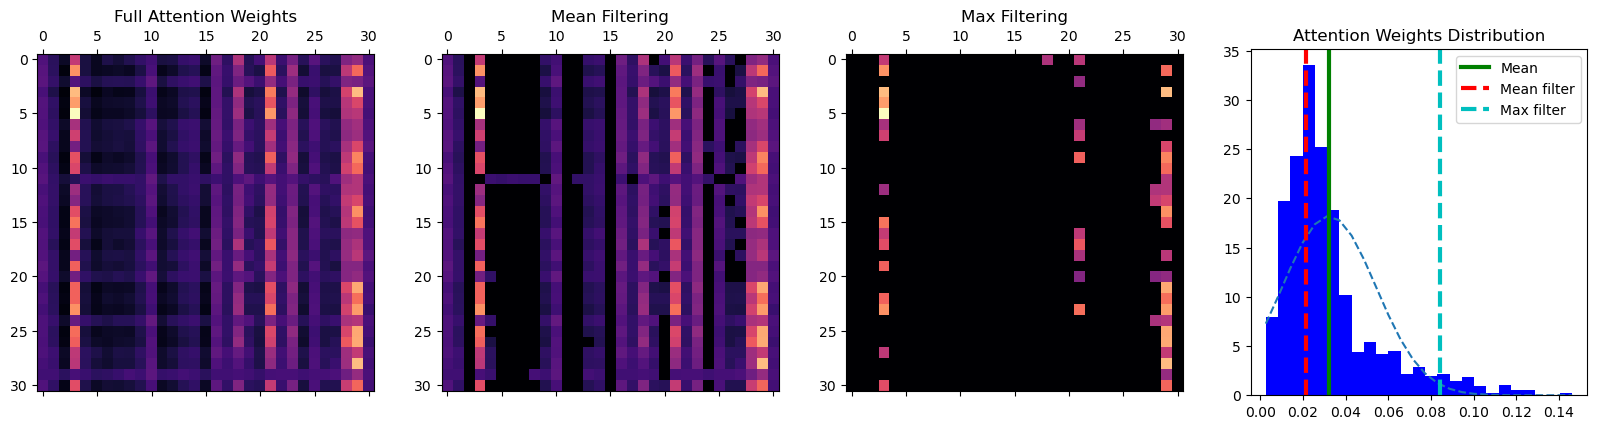


Document ID:  670 -- #Sentences:  10
Source text:
  Navajo Nation President Russell Begaye, on Tuesday’s airing of CNN’s “New Day,” insisted that even in 2017, every “non Indian out there” is a “guest of Native Americans.” Speaking with CNN’s Alisyn Camerota and actor, producer, and founder of American Indians in Film and Television, Sonny Skyhawk, Begaye discussed  Later during the interview, Camerota asked Begaye what he wanted from the president after Monday’s viral “Pocahontas” incident. “What do you want from the president? Do you want an apology?” Camerota asked. Begaye responded that he wants Trump to continue honoring Navajo “code talkers” and veterans and respect their sacrifices. He explained, “That’s who we are as Americans, we thank each other, especially in defense of freedom of this great nation, and for Native Americans, this is our land.” “Every inch of it, every mountain, every stream, every water that is out there, it is ours,” he added. “It’s Native American country

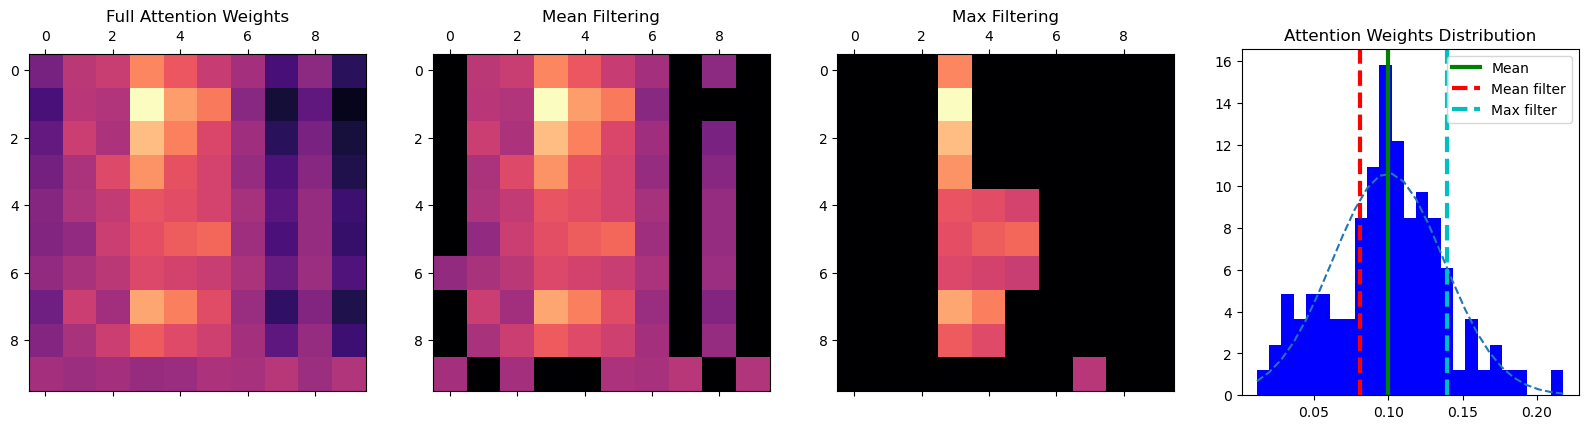


Document ID:  671 -- #Sentences:  22
Source text:
  Saul Loeb/AFP/Getty Images ST. LOUIS—Missouri has a competitive Senate race. It has a competitive governor s race. According to polls of the presidential race, though, there’s not much of a contest here in the state that Sen. Barack Obama lost by only a few thousand votes in 2008. Trump enjoys a 10.6 percentage point lead here,  But Jay Nixon, Missouri’s outgoing Democratic governor, isn’t so sure Trump can bank on the state’s 10 electoral votes just yet. “Well, he hasn’t had a good week. Haven’t seen any numbers recently,” he told Slate at Washington University ahead of Sunday’s second debate. “I think Missouri’s a state where you still have enough undecideds to get this race close. I think it will tighten. I think that his conduct over the last—both in the last debate as well as over the last 10 days—is something that jars people. This is not the way presidents are supposed to act or talk.” Nixon was walking on Wash U’s main lawn s

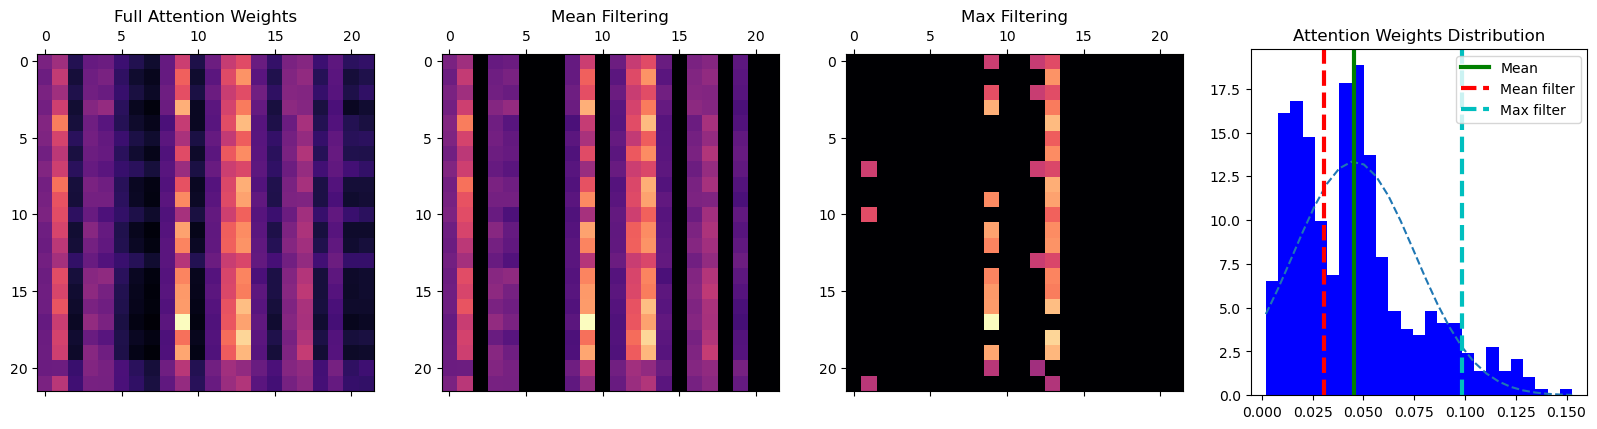

Done.


In [13]:
filtering=True
num_print = 5

# Training full
filter = "mean"
filtered_matrices, total_nodes, total_edges, deletions = filtering_matrices(full_attn_weights_t, all_article_identifiers_t, df_full_train, print_samples=num_print,
                                                                                    degree_std=std, with_filtering=filtering, filtering_type=filter, granularity=granularity)

# Test
filtered_matrices_test, total_nodes_test, total_edges_test, deletions_test = filtering_matrices(full_attn_weights_test, all_article_identifiers_test, df_test, print_samples=num_print,
                                                                                    degree_std=std, with_filtering=filtering, filtering_type=filter, granularity=granularity)



##### Sigmoid 

In [14]:
model_name= "Extended_Sigmoid" 
path_checkpoint, model_score = retrieve_parameters(model_name, df_logger, require_best=False, retrieve_index=18)
loader_train, loader_test, vocab_sent, invert_vocab_sent = create_loaders(df_full_train, df_test, max_len, batch_size, with_val=False,
                                                                                               tokenizer_from_scratch=False, path_ckpt=in_path)
print ("\nLoading", model_name, "({0:.3f}".format(model_score),") from:", path_checkpoint)
model_lightning = MHAClassifier.load_from_checkpoint(path_checkpoint)
print ("Model temperature", model_lightning.temperature)

preds_t, full_attn_weights_t, all_labels_t, all_doc_ids_t, all_article_identifiers_t = model_lightning.predict(loader_train, cpu_store=False)
preds_test, full_attn_weights_test, all_labels_test, all_doc_ids_test, all_article_identifiers_test = model_lightning.predict(loader_test, cpu_store=False)
acc_t, f1_all_t = eval_results(preds_t, all_labels_t, num_classes, "Train")
acc_test, f1_all_test = eval_results(preds_test, all_labels_test, num_classes, "Test") 


Loading Extended_Sigmoid (0.764 ) from: /scratch/mbugueno/HomoGraphs_HND/Extended_Sigmoid/Extended_Sigmoid-epoch=04-Val_f1-ma=0.76.ckpt
Model temperature 1

Trained Model Results on partition: Train
Train Acc: tensor(0.9208)
Train F1-score macro: tensor(0.9165)
Train F1-score for each class: tensor([0.9355, 0.8974])

Trained Model Results on partition: Test
Test Acc: tensor(0.7648)
Test F1-score macro: tensor(0.7645)
Test F1-score for each class: tensor([0.7554, 0.7735])



Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  0 -- #Sentences:  60
Source text:
  Money (  The walls are closing in on Congress. Terrifying walls of water from Hurricanes Harvey and Irma, which, when the damage is totaled, could rise to a half trillion dollars. The Walls of War: The multi trillion dollar ongoing cost of Afghanistan, Iraq and other interventions. The crumbling walls of the U.S. infrastructure, which need at least $3 trillion to be repaired or replaced. A wall of 11 million undocumented immigrants, whose deportation could easily cost $200 billion. The planned wall at the Mexican border, which some estimates place at $67 billion. Then there is the Wall of All, the $20 trillion national debt. The walls of debt are closing in. At moments of crisis in our nation, in addition to invoking the assistance of Higher powers, we can call upon the Constitution for guidance. Article I, Section 8, of the U.S. Constitution contains a long forgotten pro

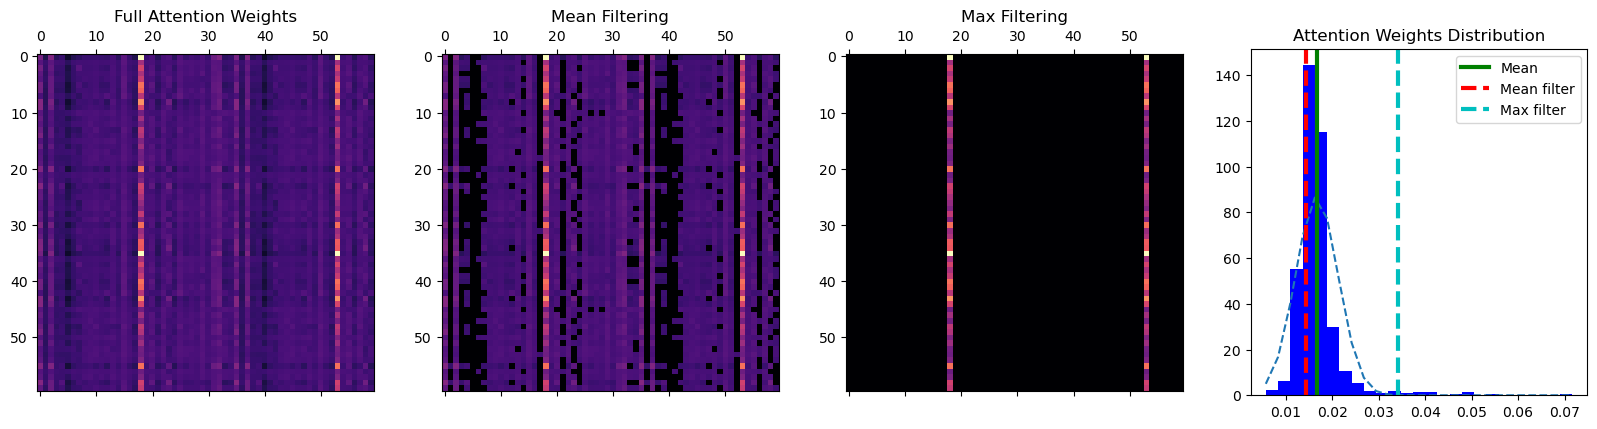


Document ID:  2 -- #Sentences:  11
Source text:
  In response to Joyce Newman’s recent letter about a conversation about guns: According to the National Right to Life Organization, approximately 600,000 babies are murdered every year by Planned Parenthood with more than 52 million murdered since Roe v. Wade. This makes Planned Parenthood the biggest mass murderer in the history of the world. Is she willing to have a serious conversation about that? Where is her outrage over that? More people die every year from overdoses or auto accidents then from guns. More people die every year from obesity then from guns. Where is her outrage over those issues? The left’s obsession with gun “control” is just that, control. It has always been about Democrats wanting to control every aspect of your life. They support Planned Parenthood but go ballistic when a gun is used to kill someone. It’s the old game of “don’t pay any attention to what’s going on over there, but look what’s happening here.”
Aft

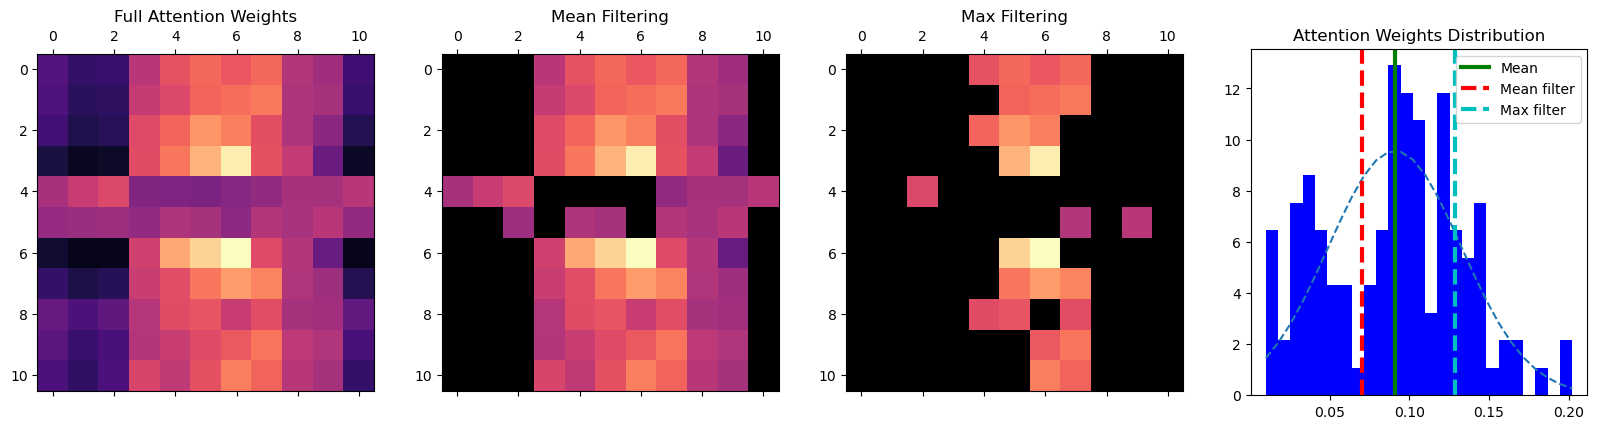


Document ID:  3 -- #Sentences:  17
Source text:
  After Colin Kaepernick rightly chose to kneel during the national anthem before NFL games, many racists and idiots came out with critical response to what was a peaceful, important statement against police brutality and systemic American racism. That’s what Kap’s protest is about. Brutality and racism. Violence against people of color, unimpugned state violence at that. Kap’s protest is strictly against racism, which is what this country was built on. On the backs of African slaves shipped here catch style to do white people’s work. Kap’s protest is decidedly not against the American flag. Anyone — including our moron President — that tries to argue otherwise is themselves a moron. “But the troops!” you might scream. The troops are a manifold and variegated thing.  Here’s a picture of  He kneels at left. Hat off to Tunsil for this action. “Respecting the flag” and “respecting the anthem” before football games are perhaps the dumbest no

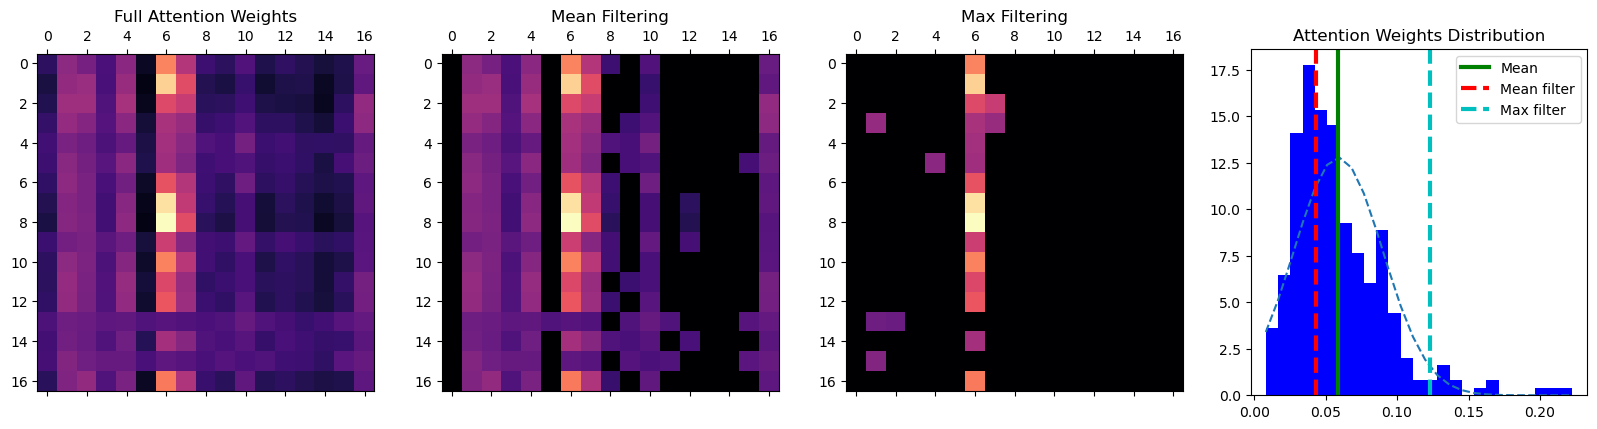


Document ID:  4 -- #Sentences:  45
Source text:
  Almost a half century ago, in 1968, the United States seemed to be falling apart. The Vietnam War, a bitter and close presidential election, antiwar protests, racial riots, political assassinations, terrorism and a recession looming on the horizon left the country divided between a loud radical minority and a silent conservative majority. The United States avoided a civil war. But America suffered a collective psychological depression, civil unrest, defeat in Vietnam and assorted disasters for the next decade    until the election of a once polarizing Ronald Reagan ushered in five consecutive presidential terms of relative bipartisan calm and prosperity from 1981 to 2001. It appears as if 2017 might be another 1968. Recent traumatic hurricanes seem to reflect the country s human turmoil. After the polarizing Obama presidency and the contested election of Donald Trump, the country is once again split in two. But this time the divide is 

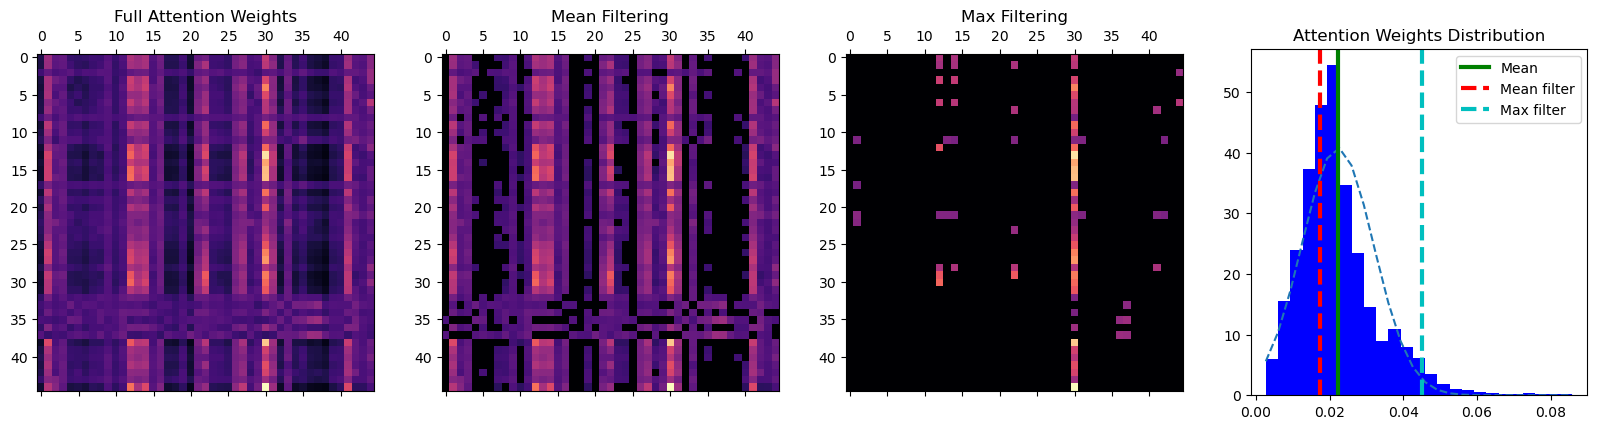


Document ID:  5 -- #Sentences:  109
Source text:
  Briefly: In our opinion, full (150% of the regular full position) speculative short positions in gold, silver and mining stocks are justified from the risk/reward perspective at the moment of publishing this alert. Gold moved back and forth on Friday and the accompanying volume was high, but that’s not the only important thing that we can discuss today. The week is over and we have weekly changes and weekly volume levels to analyze and we saw major moves in the important ratios. Additionally, we discovered a self similar pattern in gold that has critical and volatile implications going forward. Let’s start with Friday’s session and the changes in the gold market (chart courtesy of  Gold moved sharply back and forth as both positive and negative data was released and ultimately it ended the session a few dollars higher (based on kitco’s prices, the closing price was $1,279.60). Why was the reaction so significant? The reason could be t

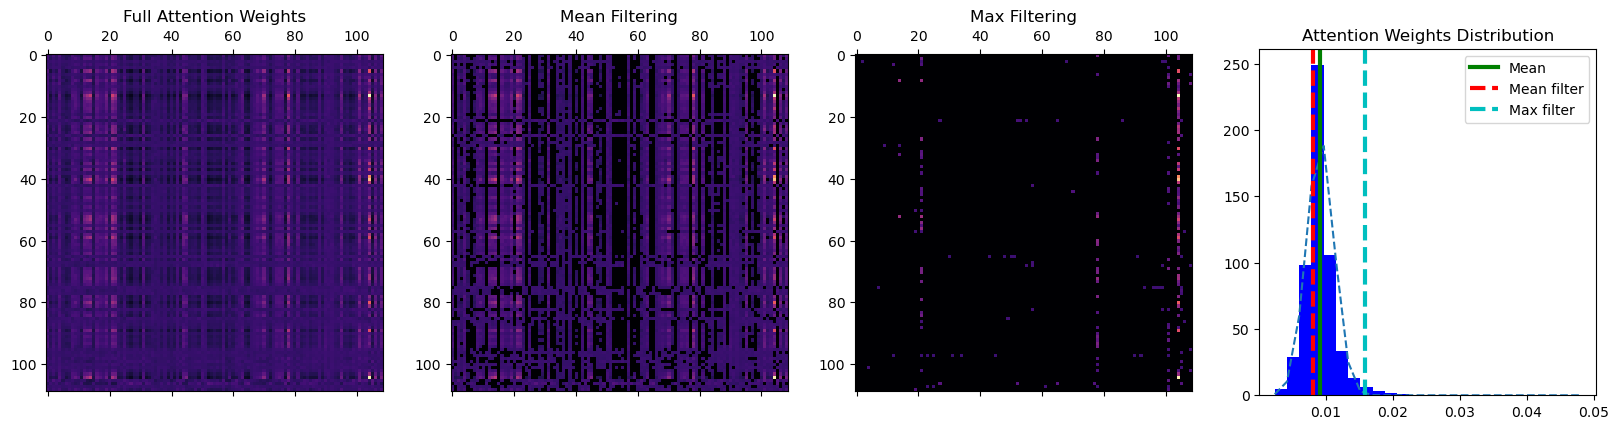

Done.

Filtering Attention Weights based on Max/Mean and Std Deviation

Document ID:  661 -- #Sentences:  10
Source text:
  Members of Texas Vanguard, a white supremacist group, hung racist and homophobic propaganda across the Southern Methodist University campus in Dallas over the weekend. “White men! Save your people. Reject the opioid beast!” was the message on a banner posted at the lacrosse field. The group touted its work on Twitter, “We had a great night @SMU,” sharing photos of masked members posing next to the banners while giving the Nazi salute.   Other messages said the LGBT community has “misplaced pride” and “Reclaim America. No more tolerance, no more diversity.” “While SMU strongly supports freedom of speech and expression, the outside group featured on these signs promotes an abhorrent message that is opposite to SMU values. Our University community is deeply committed to maintaining an educational environment that is welcoming and inclusive. As an institution dedicate

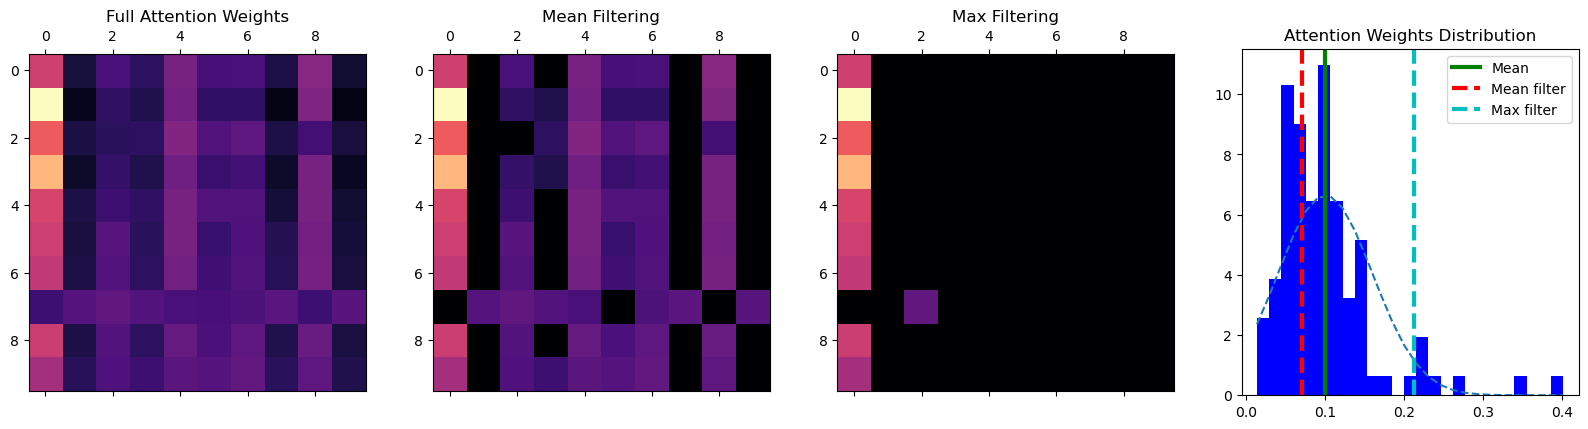


Document ID:  664 -- #Sentences:  12
Source text:
  FBI special agent Aaron Rouse, the chief of the FBI’s Las Vegas office, revealed Wednesday that the agency might not be able to reveal Las Vegas shooter Stephen Paddock’s motive until October. Rouse, who spoke to the  “Now that’s a long time for some people, but speaking for the FBI, that’s light speed, all right?” Rouse said. “And again, it will be thorough.” “[The FBI’s report] is focusing a large part on the why, OK? Which is what everybody wants to know,” Rouse reported. He added that through a thorough investigation of the incident, including those whom the FBI interviewed — upward of 400 people who had even the smallest connection with Paddock, according to the Review Journal — he is confident that a comprehensive report will be released by October. “I’ve said this before: I believe at the end of this investigation we will have as many answers as we possibly can without talking to the subject themselves,” Rouse explained. “I am

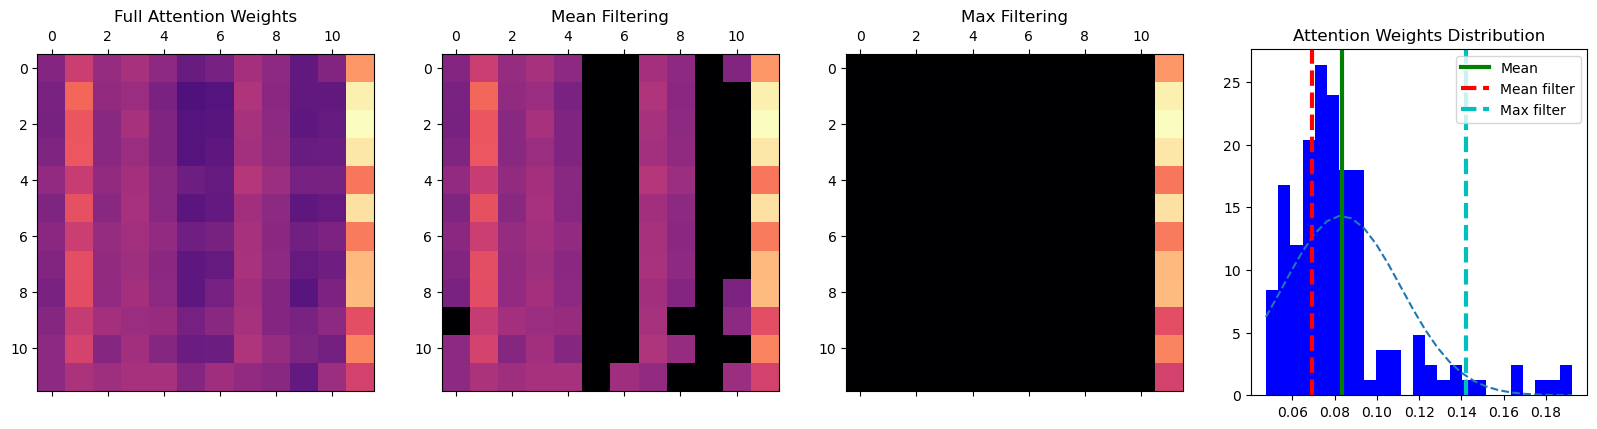


Document ID:  667 -- #Sentences:  31
Source text:
  After a few weeks off,  The comedian addressed the week’s biggest controversy during his monologue—Trump finally acknowledging after being at the forefront of a five year racist crusade against the first black president that Barack Obama was born in the United States. As is his wont, the bloated ex reality show host delivered the news  “He blamed it on Hillary. Of course,” said Maher, rolling his eyes. “Because even when [Trump] admits he lies, he has to tell another giant lie! He says Hillary and her campaign started birtherism in 2008, which is something contradicted only by newspapers, television, Twitter, eyes, ears, and smell. Hillary started birtherism? Oh yes, I think we all remember that. I think it was right after Hillary’s casinos went bankrupt.” A softball, Fallon esque softball interview with Trump campaign manager Kellyanne Conway—who’s been a guest and pal of Maher’s for twenty years dating back to his ABC series Politi

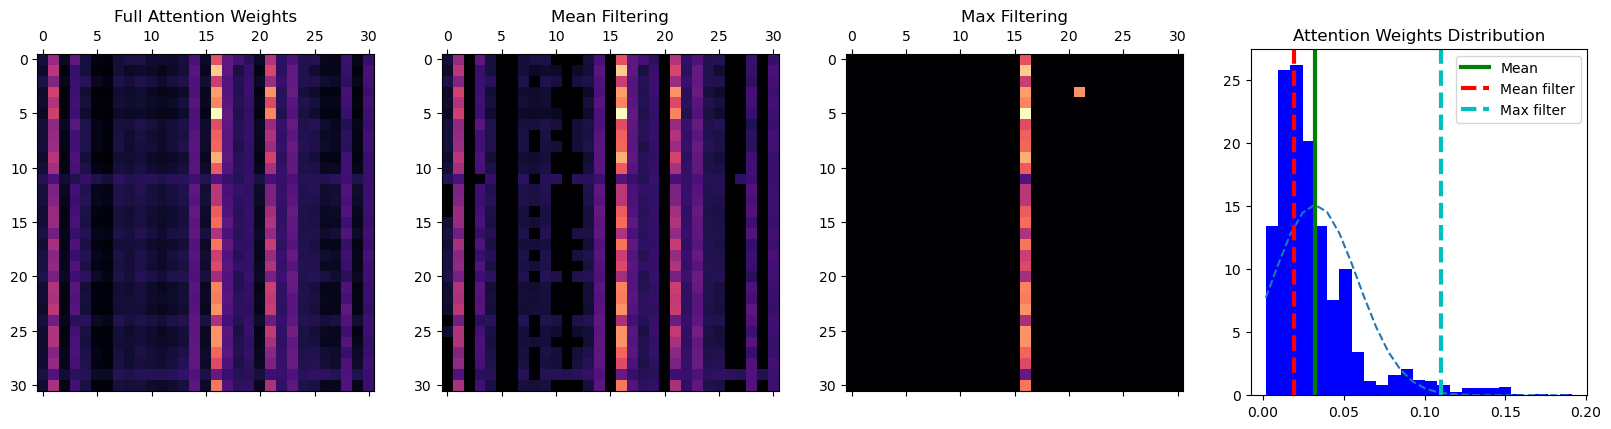


Document ID:  670 -- #Sentences:  10
Source text:
  Navajo Nation President Russell Begaye, on Tuesday’s airing of CNN’s “New Day,” insisted that even in 2017, every “non Indian out there” is a “guest of Native Americans.” Speaking with CNN’s Alisyn Camerota and actor, producer, and founder of American Indians in Film and Television, Sonny Skyhawk, Begaye discussed  Later during the interview, Camerota asked Begaye what he wanted from the president after Monday’s viral “Pocahontas” incident. “What do you want from the president? Do you want an apology?” Camerota asked. Begaye responded that he wants Trump to continue honoring Navajo “code talkers” and veterans and respect their sacrifices. He explained, “That’s who we are as Americans, we thank each other, especially in defense of freedom of this great nation, and for Native Americans, this is our land.” “Every inch of it, every mountain, every stream, every water that is out there, it is ours,” he added. “It’s Native American country

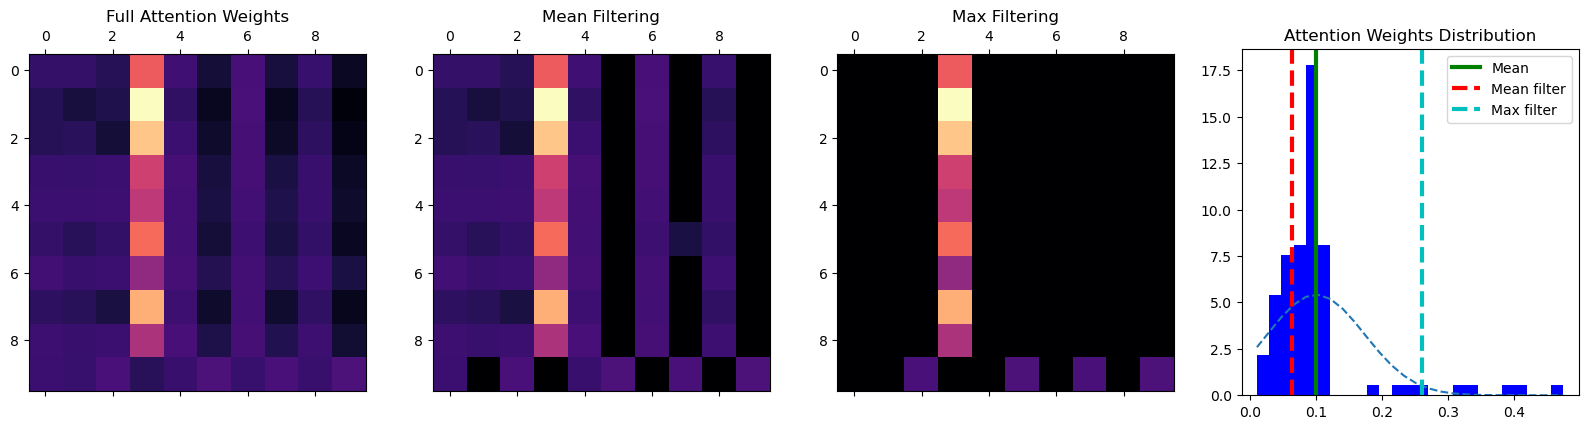


Document ID:  671 -- #Sentences:  22
Source text:
  Saul Loeb/AFP/Getty Images ST. LOUIS—Missouri has a competitive Senate race. It has a competitive governor s race. According to polls of the presidential race, though, there’s not much of a contest here in the state that Sen. Barack Obama lost by only a few thousand votes in 2008. Trump enjoys a 10.6 percentage point lead here,  But Jay Nixon, Missouri’s outgoing Democratic governor, isn’t so sure Trump can bank on the state’s 10 electoral votes just yet. “Well, he hasn’t had a good week. Haven’t seen any numbers recently,” he told Slate at Washington University ahead of Sunday’s second debate. “I think Missouri’s a state where you still have enough undecideds to get this race close. I think it will tighten. I think that his conduct over the last—both in the last debate as well as over the last 10 days—is something that jars people. This is not the way presidents are supposed to act or talk.” Nixon was walking on Wash U’s main lawn s

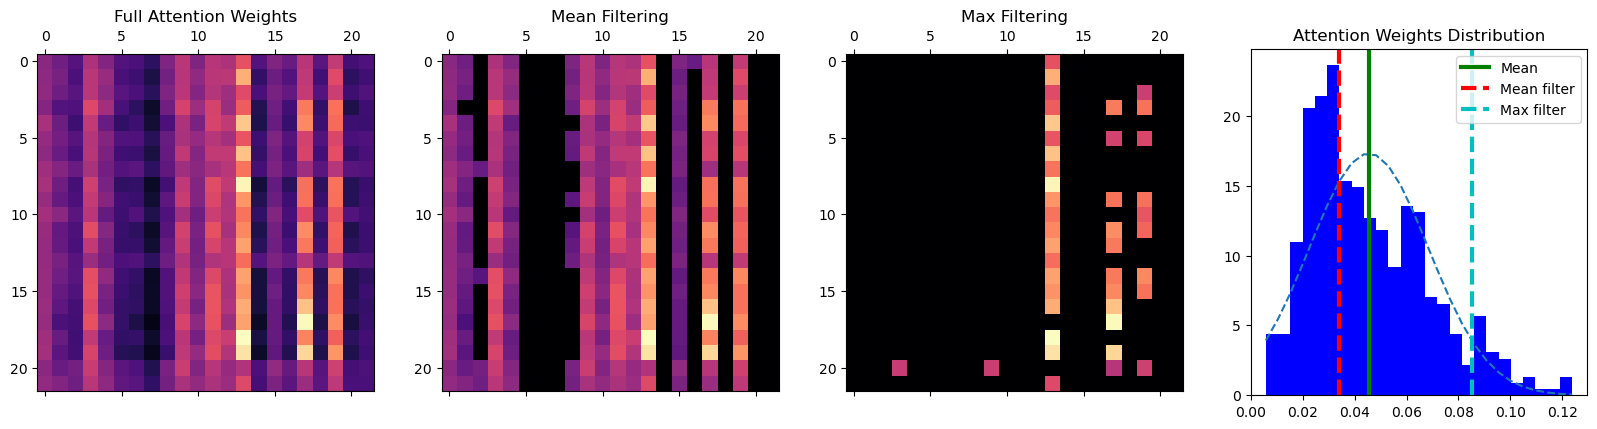

Done.


In [15]:
filtering=True
num_print = 5
filter = "mean"
filtered_matrices, total_nodes, total_edges, deletions = filtering_matrices(full_attn_weights_t, all_article_identifiers_t, df_full_train, print_samples=num_print,
                                                                                    degree_std=std, with_filtering=filtering, filtering_type=filter, granularity=granularity)

filtered_matrices_test, total_nodes_test, total_edges_test, deletions_test = filtering_matrices(full_attn_weights_test, all_article_identifiers_test, df_test, print_samples=num_print,
                                                                                    degree_std=std, with_filtering=filtering, filtering_type=filter, granularity=granularity)

##### Distributions

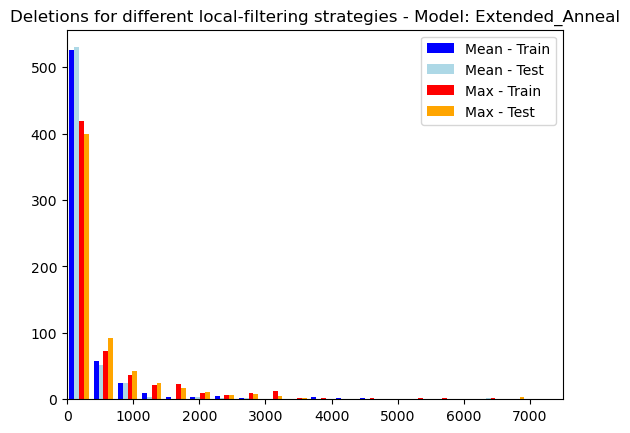

In [26]:
plt.hist(x=[deletions, deletions_test, max_deletions, max_deletions_test], bins=50, color=['blue', 'lightblue', 'red', 'orange'])
plt.xlim(0, 7500)
plt.legend(["Mean - Train", "Mean - Test", "Max - Train", "Max - Test"])
plt.title("Deletions for different local-filtering strategies - Model: "+model_name)
plt.show()

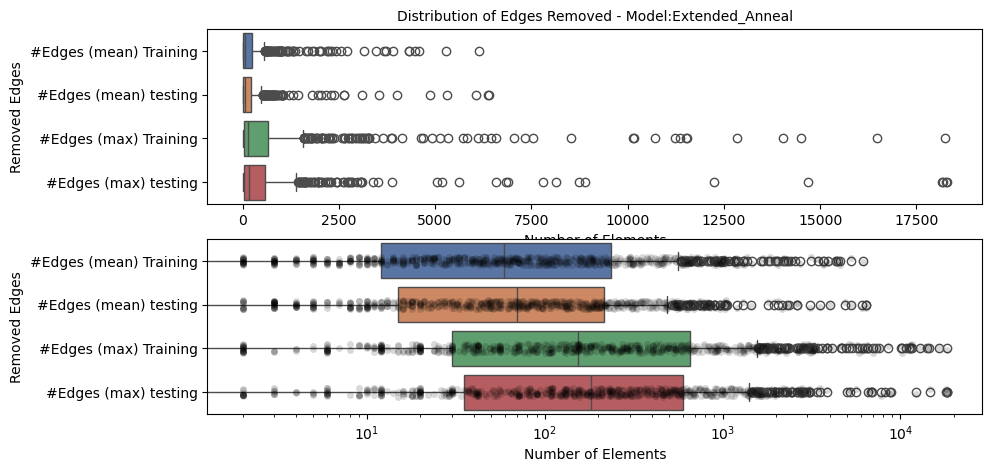

In [27]:
f, axarr = plt.subplots(2,1, figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.boxplot(data=(deletions, deletions_test, max_deletions, max_deletions_test), orient='h', ax=axarr[0])
axarr[0].axes.set_title("Distribution of Edges Removed - Model:"+model_name, fontsize=10)
axarr[0].set_ylabel("Removed Edges", fontsize=10)
axarr[0].set_xlabel("Number of Elements", fontsize=10)
axarr[0].set_yticklabels(('#Edges (mean) Training','#Edges (mean) testing', '#Edges (max) Training','#Edges (max) testing'), fontsize=10)


sns.boxplot(data=(deletions, deletions_test, max_deletions, max_deletions_test), orient='h', ax=axarr[1])
ax = sns.stripplot(data=(deletions, deletions_test, max_deletions, max_deletions_test), marker="o", alpha=0.15, color="black", orient='h')
#axarr[1].axes.set_title("Distribution of Edges Removed", fontsize=10)
axarr[1].set_ylabel("Removed Edges", fontsize=10)
axarr[1].set_xlabel("Number of Elements", fontsize=10)
axarr[1].set_yticklabels(('#Edges (mean) Training','#Edges (mean) testing', '#Edges (max) Training','#Edges (max) testing'), fontsize=10)
axarr[1].set_xscale('log', base=10)

plt.show()

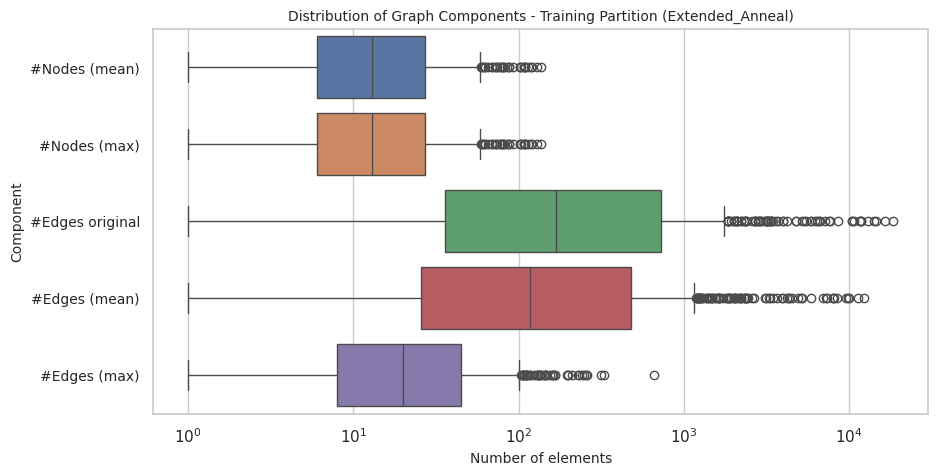

In [28]:
original_edges= [itema+itemb for itema, itemb in zip(total_edges,deletions)]
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.boxplot(data=(total_nodes, max_total_nodes, original_edges, total_edges, max_total_edges), orient='h')
plt.title("Distribution of Graph Components - Training Partition ("+model_name+")", fontsize=10)
plt.ylabel("Component", fontsize=10)
plt.xlabel("Number of elements", fontsize=10)
plt.yticks([0,1,2,3,4], labels=['#Nodes (mean)', '#Nodes (max)','#Edges original','#Edges (mean)', '#Edges (max)'], fontsize=10)
plt.xscale('log', base=10)

plt.show()

In [29]:
print ("#Avg. Nodes in Doc", np.mean(total_nodes)) #mean
print ("#Avg. Edges in Doc", np.mean(total_edges)) #mean


#Avg. Nodes in Doc 20.517080745341616
#Avg. Edges in Doc 591.3664596273292


###### https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9709990
